# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
!ls data/C2A2_data

BinSize_d400.csv  fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv


In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [3]:
!ls data/C2A2_data

BinSize_d400.csv  fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv


In [4]:
hash_id = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'
df = pd.read_csv('data/C2A2_data/{}'.format(hash_id))
#df.sort_values(["Date",'ID'])
# Convert Date column from string to datetime type
df.Date = pd.to_datetime(df.Date)
# create new column only with years
df['Year'] = df.Date.dt.year
# create a new column with Month-Day values
df['Month-day'] = df.Date.dt.strftime("%m-%d")


In [5]:
print("Number of data points wo 02-29 days (leap year): {}".format(df[~(df['Month-day'] == '02-29')].shape[0]//2))
print("Number of data points 02-29 days (leap year): {}".format(df[(df['Month-day'] == '02-29')].shape[0]//2))
print("Proportion {}".format((df[df['Month-day'] == '02-29'].shape[0]//2) / (df.shape[0]//2)))
print("Does not make sense to add that points")

Number of data points wo 02-29 days (leap year): 82501
Number of data points 02-29 days (leap year): 41
Proportion 0.0004967168229507402
Does not make sense to add that points


In [6]:
# Remove 02-29-xxxx
df = df[~(df['Month-day'] == '02-29')]
# COnvert tenths of Celcius into Celcius
df['Data_Value'] *= .1
# separate into two dataframes one with data of 2015 and another with all the previous data
df_2015 = df[df['Year'] == 2015]
df = df[df['Year'] != 2015] 

In [7]:
# Retrieve the Max/Min values, group by Month-day, per each Month-day calculate the Max/Min value
# So I end with one max and min value for each Month-day value
max_2015 = df_2015[df_2015.Element == 'TMAX'].groupby('Month-day').agg({'Data_Value': np.max})
min_2015 = df_2015[df_2015.Element == 'TMIN'].groupby('Month-day').agg({'Data_Value': np.min})
# calculate the same for values before 2015
max_df = df[df.Element == 'TMAX'].groupby('Month-day').agg({'Data_Value': np.max})
min_df = df[df.Element == 'TMIN'].groupby('Month-day').agg({'Data_Value': np.min})

In [8]:
# Calcualte the Month-day values where the temperature of 2015 
# was higher of the max values or lower than the minimun
outliers_max = np.where(max_2015 > max_df)[0]
outliers_min = np.where(min_2015 < min_df)[0]

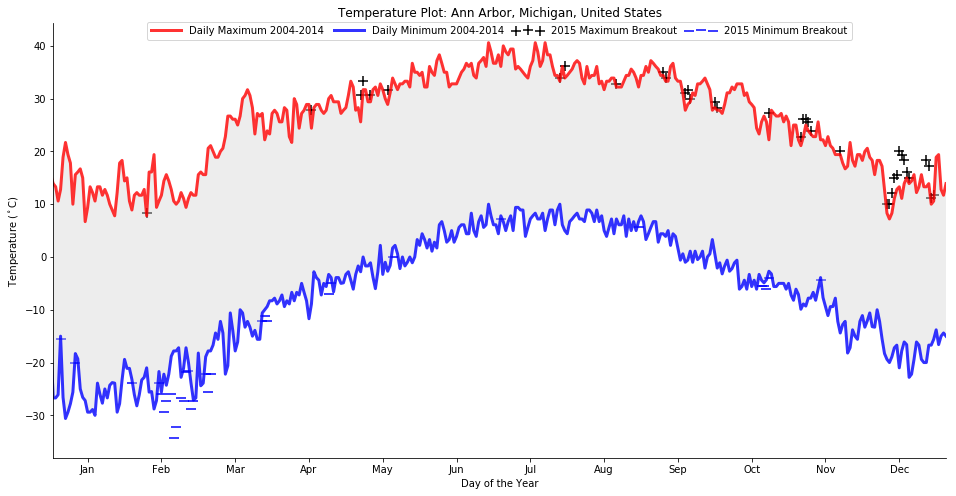

In [30]:

# Plotting
plt.figure(figsize=(16,8))
plt.plot(max_df.values, c='red', linewidth=3, alpha=0.8, label='Daily Maximum 2004-2014')
plt.plot(min_df.values, c='blue', linewidth=3, alpha=0.8, label='Daily Minimum 2004-2014')
plt.scatter(outliers_max, max_2015.iloc[outliers_max], s=100, c='black', marker="+", label='2015 Maximum Breakout')
plt.scatter(outliers_min, min_2015.iloc[outliers_min], s=100, c='b', marker="_", label='2015 Minimum Breakout')
plt.gca().fill_between(range(len(max_df.values)), 
                       min_df['Data_Value'], max_df['Data_Value'], 
                       facecolor='lightgray',
                       alpha=0.40)
plt.xticks(
    np.linspace(15,15 + 30*11 , num = 12),
    (r'Jan', r'Feb', r'Mar', r'Apr', r'May', r'Jun', r'Jul', r'Aug', r'Sep', r'Oct', r'Nov', r'Dec') )

plt.xlim(1, 364)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.1, .95, 0.8, .95), loc=3, ncol=4, mode='expand',
                    handlelength=3, scatterpoints=3)

plt.xlabel('Day of the Year')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Temperature Plot: Ann Arbor, Michigan, United States')
plt.show()